# Import data


In this notebook, we look at import functions and how to assign data to the grid. 

---

We import the class (as explained in turorial 1): 

In [1]:
#from agrid import *

# or:

config_file = "../grid_code/agrid.py"
with open(config_file) as f:
    code = compile(f.read(), config_file, 'exec')
    exec(code, globals(), locals())

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


I m in sub!!!!


Now we make two grid objects, one of the Antarctic continent in  [EPSG:3031. WGS 84 / Antarctic Polar Stereographic projection](https://epsg.io/3031) and also a global model, using [WGS84](https://epsg.io/4326). Resolution is defined in the unit of the projection, meters for stereographic projection, and degrees for the global grid. The coordinates in the xarray dataset are stored as dask arrays, they are not loaded until they are needed. When processed, they are loaded as smaller chunks, 1/10 of the axes large. 

In [2]:
#Continental
ant = Grid(crs=3031, res = [10*km, 10*km], left = -3100*km, up=3100*km, right = 3100*km, down = -3100*km)

print(ant.ds)

#Global (almost)
world = Grid(crs=4326, res = [1, 1], left = -180, up=90, right = 180, down = -90)

print(world.ds)

<class 'str'> +init=epsg:3031
<class 'str'> +init=epsg:4326
<xarray.Dataset>
Dimensions:  (RGB: 3, X: 619, Y: 619, Z: 5)
Coordinates:
  * X        (X) float32 -3095000.0 -3084983.8 ... 3084983.8 3095000.0
  * Y        (Y) float32 3095000.0 3084983.8 3074967.8 ... -3084983.8 -3095000.0
  * Z        (Z) float32 0.0 8000.0 16000.0 40000.0 350000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(619, 619), chunksize=(61, 61)>
    YV       (Y, X) float32 dask.array<shape=(619, 619), chunksize=(61, 61)>
    lat      (Y, X) float32 dask.array<shape=(619, 619), chunksize=(61, 61)>
    lon      (Y, X) float32 dask.array<shape=(619, 619), chunksize=(61, 61)>
Data variables:
    *empty*
<class 'str'> +init=epsg:4326
<class 'str'> +init=epsg:4326
<xarray.Dataset>
Dimensions:  (RGB: 3, X: 359, Y: 179, Z: 5)
Coordinates:
  * X        (X) float32 -179.5 -178.49721 -177.49442 ... 178.49721 179.5
  * Y        (Y) float32 89.5 88.494385 87.48876 ... -87.48876 -88.494385 

We download a raster, in this case the global 1:50m Bathymetry. It is 66Mb. 

In [3]:
! mkdir -p ../../data/ne
! wget -nc https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/HYP_50M_SR_W.zip \
    -O ../../data/ne/HYP_50M_SR_W.zip
    
! unzip -n ../../data/ne/HYP_50M_SR_W.zip -d ../../data/ne

File ‘../../data/ne/HYP_50M_SR_W.zip’ already there; not retrieving.
Archive:  ../../data/ne/HYP_50M_SR_W.zip


We import the raster to the global grid and to the Antarctic grid: 
The raster has three channels, so we assign it to X, Y and RGB coordinates. This might also take some time, as the raster needs to be warped to each grid cell. We can speed up a bit by subsampling the raster before warp. 

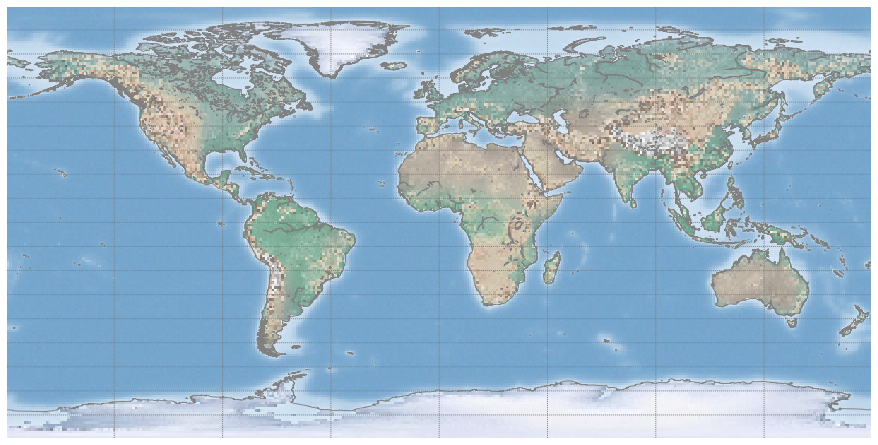

In [4]:
world.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), 
                world.read_raster('../../data/ne/HYP_50M_SR_W/HYP_50M_SR_W.tif', sub_sampling=5))

world.map_grid('RGB_RASTER')


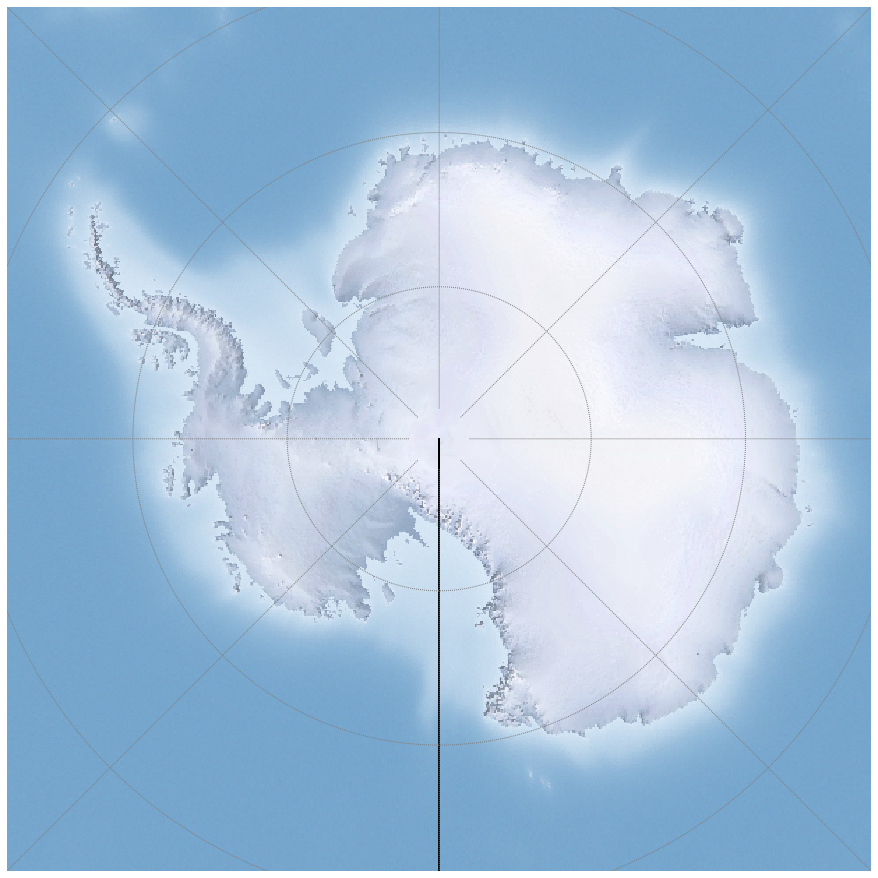

In [7]:
ant.ds['RGB_RASTER'] = (('Y', 'X', 'RGB'), ant.read_raster('../../data/ne/HYP_50M_SR_W/HYP_50M_SR_W.tif', sub_sampling=4) )

ant.map_grid('RGB_RASTER', draw_coast=False)

read_raster returns a numpy array, that is assigned to the dataFrame and liked to coordinates (Y, X, and RGB). As explaned earlier, Y comes before X as arrays are indexed rows-columns. 

sub_sampling sybsamples unnecisary large arrays before reprojecting. Source extra adds some extra cells around the margin to ensure that the dateline is correctely rendered. 

Pretty, but the raison d'etre for this code is to work properly with 3D models. We download AN-1S sesimic 3D model of the Antarctic lithosphere. 

In [ ]:
! mkdir -p ../../data/an
! wget -nc http://www.seismolab.org/model/antarctica/lithosphere/AN1-Ts_depth_grd.tar.gz \
    -O ../../data/an/AN1-S_depth_grd.tar.gz
! tar -xvzf ../../data/an/AN1-S_depth_grd.tar.gz -C ../../data/an/

In [ ]:
import glob

an_files = sorted(glob.glob('../../data/an/*.grd'))
#print(an_files)
ant.ds.coords['AN_Z'] = [np.float32(d[-9:-4])*km for d in an_files]
str_depths = [str(d[-9:-4]) for d in an_files]


an_array = np.empty((ant.nx, ant.ny, len(an_files)))
an_array[:] = np.nan
for i, a in enumerate(ant.ds.coords['AN_Z'].values):
    print(a//km, end=' ')
    fname = '../../data/an/AN1-S_hslice_%s.grd'%str_depths[i]
    if os.path.isfile(fname):
        an_array[:,:,i] = ant.read_grid(fname, xyz = ('x','y','z') ) 
    
ant.ds['AN_S'] = (('X', 'Y', 'AN_Z'), an_array)


In [ ]:
ant.map_grid(ant.ds['AN_S'].sel(AN_Z=325*km), cmap='magma_r', line_w=2, line_c='w', cbar=True)

Say we want to look at a 1D velocity model, e.g. [AK135, Kennett, Engdahl & Buland (1995)](http://rses.anu.edu.au/seismology/ak135/ak135f.html). We can read directely from IRIS url and import it to our grid. 

In [ ]:
url_ak135 = 'http://ds.iris.edu/files/products/emc/data/AK135F/AK135F_AVG.csv'
ak_135_d, _, ak_135_vp, ak_135_vs,_,_  = np.genfromtxt(url_ak135, delimiter=',', unpack=True)*km #To SI unit

plt.plot(ak_135_vs, -ak_135_d/km)
plt.show()

ant.ds.coords['AK135_Z'] = ak_135_d
ant.ds['AK135_SV'] = (('AK135_Z'), ak_135_vs)

Say we want to compare AN_S model with AK135 at 315km, but the depth value is not defined in AK135. 

In [ ]:
ant.ds['AK135_SV_LITH'] = ( ('AN_Z'), 
                           ant.change_coord(ant.ds['AK135_SV'], ant.ds['AK135_Z'], ant.ds['AN_Z'], axis=-1) )

A = ant.ds['AN_S'].mean(dim=['X', 'Y'])*km

plt.plot(ant.ds['AK135_SV_LITH'], -ant.ds['AN_Z']/km, A, -ant.ds['AN_Z']/km)
plt.show()

We set up a toy example. We would like to use AK135 to calculate the perturbation in AN1-S, but only for West Antarctica. We have a shapefile that defines the area we are interested in: 

In [ ]:
ant.ds['WEST_ANTARCTICA'] = (('Y', 'X'), 0 < ant.assign_shape('../../data/vector/west_antarctica_defined.shp', 'Land'))

In [ ]:
ant.ds['WEST_AN_S'] = ant.ds['WEST_ANTARCTICA'] * ant.ds['AN_S']

#.fillna(0)

ant.map_grid(ant.ds['WEST_AN_S'][:,:,4], cmap='magma_r')

## A detailed map

Now we try a high resolution dataset with a different projection. 

Again, we download some data, both raster and vector. Ref: [Norwegian Polar Institute 2014](https://data.npolar.no/dataset/19700322-beab-40e7-b867-c3f0c2756071)

Basemap is used to produce maps from the grid, it supports a [large range](https://matplotlib.org/basemap/users/mapsetup.html) of projections, but not all. [epsg 32731](https://epsg.io/32731) is not supported, but we can always use standard matplotlib or mayavi as the grid is regularly sampled. 

In [ ]:
#Make object
bouvet = Grid(crs_tgt=32731, res = [5, 5], 
             up = 3974168, 
             left=517217 , 
             down = 3965208, 
             right = 529277)

print(bouvet.ds)

In [ ]:
! mkdir -p ../../data/bouvet

! wget -nc https://publicdatasets.data.npolar.no/kartdata/NP_B0_DTM20.zip \
    -O ../../data/bouvet/NP_B0_DTM20.zip 
! unzip -n ../../data/bouvet/NP_B0_DTM20.zip -d ../../data/bouvet

! wget -nc https://publicdatasets.data.npolar.no/kartdata/NP_B20_SHP.zip \
    -O ../../data/bouvet/NP_B20_SHP.zip
! unzip -n ../../data/bouvet/NP_B20_SHP.zip -d ../../data/bouvet

! wget -nc https://content.satimagingcorp.com/static/galleryimages/landsat%208%20bouvet%20island%20lg.jpg \
    -O ../../data/bouvet/landsat_bouvet.jpg

In [ ]:
bouvet.ds['DEM'] = (('Y', 'X'), 
                bouvet.read_raster('../../data/bouvet/NP_B0_DTM20/B0_DTM20.tif'))



In [ ]:
bouvet.ds['LAND'] = (('Y', 'X'), 
                     bouvet.assign_shape('../../data/bouvet/NP_B20_SHP/B20_Land_f.shp', None, burn_val=1) )

In [ ]:
plt.imshow(bouvet.ds['LAND'].values)
plt.show()

plt.imshow(bouvet.ds['DEM'].values)
plt.show()
bouvet.ds['DEM'][:,1222]